In [1]:
# pip installs if needed (uncomment if running in a fresh environment)
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
import os

# ---------------------------
# Configuration / Parameters
# ---------------------------
CSV_PATH = "./station_trains_30.csv"  # change if needed
HORIZON_MINUTES = 180  # scheduling horizon in minutes (from earliest ETA)
TIME_UNIT = 1  # 1 minute time unit
BASE_BUFFER = 1  # base buffer between trains on same track (minutes)
UNCERTAINTY_MARGIN = 1  # multiplier for ETA uncertainty -> buffer
LOOP_PENALTY = 5  # minutes penalty when assigning the Loop track (encourages avoid)
MAX_SOLVE_TIME_S = 30  # seconds to allow the solver
# Map tracks: directionality rules
TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}
PLATFORMS = {  # simple platform model; tracks and platforms are same here (one resource)
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def parse_time(x):
    # Accept many formats; prefer ISO-like strings or minutes from start if numeric
    if pd.isna(x):
        return None
    if isinstance(x, (int, float)):
        # interpret as minutes offset (rare)
        return dt.datetime(2025, 1, 1, 0, 0) + dt.timedelta(minutes=float(x))
    try:
        return pd.to_datetime(x)
    except Exception:
        try:
            return dt.datetime.strptime(x, "%H:%M:%S")
        except Exception:
            return None

def minutes_between(a, b):
    return int((b - a).total_seconds() // 60)

# ---------------------------
# Load dataset
# ---------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Please place station_trains_30.csv in notebook folder.")

df = pd.read_csv(CSV_PATH)
# required columns expected (but we'll fallback if missing): train_id, direction, eta, dwell_time, priority, length, eta_uncertainty
# display first rows for user
print("Dataset preview:")
display(df.head())

# Normalize columns & defaults
if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)

if 'direction' not in df.columns:
    # user earlier indicated top->bottom / bottom->top; infer from 'route' if available or default alternate
    # Default: alternate directions
    df['direction'] = ['top2bottom' if i % 2 == 0 else 'bottom2top' for i in range(len(df))]

if 'eta' not in df.columns:
    # assume arrival offsets column or create synthetic ETA now + index minutes
    now = dt.datetime.now()
    df['eta'] = [now + dt.timedelta(minutes=5 + 2 * i) for i in range(len(df))]
else:
    df['eta'] = df['eta'].apply(parse_time)

if 'dwell_time' not in df.columns:
    df['dwell_time'] = 3  # minutes default
else:
    df['dwell_time'] = df['dwell_time'].fillna(3).astype(int)

if 'priority' not in df.columns:
    df['priority'] = 1
else:
    df['priority'] = df['priority'].fillna(1).astype(int)

if 'length' not in df.columns:
    df['length'] = 200  # default meters
else:
    df['length'] = df['length'].fillna(200).astype(int)

if 'eta_uncertainty' not in df.columns:
    df['eta_uncertainty'] = 1
else:
    df['eta_uncertainty'] = df['eta_uncertainty'].fillna(1).astype(int)

# Convert ETAs to minutes-from-horizon start
min_eta = min(df['eta'])
horizon_start = min_eta - dt.timedelta(minutes=5)  # small padding
df['eta_min'] = df['eta'].apply(lambda t: minutes_between(horizon_start, t))

# Set traversal time estimate function (simple: dwell + approach/exit)
def estimate_service_time(row):
    # service time (minutes) = approach (2) + dwell_time + exit (1) + length factor
    length_factor = math.ceil(row['length'] / 300)  # longer trains take more time
    return int(2 + row['dwell_time'] + 1 + length_factor * 1)

df['service_time'] = df.apply(estimate_service_time, axis=1)
# Make horizon large enough
horizon = max(df['eta_min'] + df['service_time']) + 60  # minutes

print(f"Scheduling horizon start: {horizon_start}  horizon (min): {horizon} minutes")

# ---------------------------
# Build CP-SAT model
# ---------------------------
model = cp_model.CpModel()

trains = df.to_dict('records')

# variables containers
assign_vars = {}  # (train_id, track) -> binary assigned to that track
start_vars = {}   # (train_id, track) -> start var for optional interval
end_vars = {}
interval_vars = {}  # (train_id, track) -> interval var (optional)
delay_vars = {}  # per train, non-negative integer = max(0, assigned_start - ETA_min)
chosen_start = {}  # final chosen start (IntVar) per train
chosen_track = {}  # string -> we will extract after solve

# For NoOverlap per track we'll collect intervals per track
track_intervals = {t: [] for t in TRACKS.keys()}

# Build variables
for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['service_time'])
    # upper bound for start time: horizon
    latest_start = horizon
    # per-train delay var
    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar

    # chosen start variable: the solver will set it using disjunctions of optionals
    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar

    # ensure delay >= start - eta_min and delay >= 0
    model.Add(dvar >= svar - eta_min)
    model.Add(dvar >= 0)

    # For each track create optional interval with assignment boolean
    track_option_binaries = []
    possible_tracks = []
    for tr_id, tr_meta in TRACKS.items():
        # enforce directionality: if track is one-way and incompatible, skip creation
        dir_ok = False
        if tr_meta.get('dir') == 'both':
            dir_ok = True
        elif tr_meta.get('dir') == 'top2bottom' and t['direction'] == 'top2bottom':
            dir_ok = True
        elif tr_meta.get('dir') == 'bottom2top' and t['direction'] == 'bottom2top':
            dir_ok = True
        if not dir_ok:
            continue

        # platform length check: we allow if there's at least one platform with length >= train length
        # (simplification: platforms interchangeable)
        has_platform = any(PLATFORMS[p]['status'] == 'open' and PLATFORMS[p]['length'] >= t['length'] for p in PLATFORMS)
        if not has_platform:
            continue

        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar

        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)
        possible_tracks.append(tr_id)

        # If assigned to this track, link chosen_start to this start
        # chosen_start == start_var when binvar == 1 (use linearization)
        # Add two implications:
        model.Add(svar == start_var).OnlyEnforceIf(binvar)
        # If not assigned, start_var can be anything (optional interval handles it)

    # Exactly one track assigned among allowable tracks:
    if len(track_option_binaries) == 0:
        # No possible track (should not happen normally); create a fallback assignment to Loop if directionally allowed
        raise RuntimeError(f"No feasible track for train {tid} given direction/platform constraints.")
    model.Add(sum(track_option_binaries) == 1)

# No overlap constraints per track (ensures single occupancy)
for tr_id, ivars in track_intervals.items():
    if len(ivars) == 0:
        continue
    # Capacity is 1 per track using NoOverlap
    model.AddNoOverlap(ivars)

# Optional: add minimal headway buffer between consecutive intervals on same track
# (Because NoOverlap prevents overlap, but may allow back-to-back with zero gap; we enforce an extra gap by adding small constraints)
# A simple method: for each pair of trains on same track, if both assigned, require separation
# This is O(n^2) but for n~30 it's fine.
for (tid1, tr1), iv1 in interval_vars.items():
    for (tid2, tr2), iv2 in interval_vars.items():
        if tr1 != tr2:
            continue
        # enforce headway only between distinct trains
        if tid1 >= tid2:
            continue
        b1 = assign_vars[(tid1, tr1)]
        b2 = assign_vars[(tid2, tr2)]
        # start1 + dur1 + buffer <= start2  OR start2 + dur2 + buffer <= start1
        # Use bool reified ordering var
        order_b = model.NewBoolVar(f"order_{tid1}_{tid2}_{tr1}")
        # if order_b true -> tid1 before tid2
        model.Add(start_vars[(tid1, tr1)] + df.loc[df['train_id'] == tid1, 'service_time'].iloc[0] + BASE_BUFFER + 
                  int(UNCERTAINTY_MARGIN * df.loc[df['train_id'] == tid1, 'eta_uncertainty'].iloc[0]) 
                  <= start_vars[(tid2, tr2)]).OnlyEnforceIf(order_b)
        # if not order_b -> tid2 before tid1
        model.Add(start_vars[(tid2, tr2)] + df.loc[df['train_id'] == tid2, 'service_time'].iloc[0] + BASE_BUFFER +
                  int(UNCERTAINTY_MARGIN * df.loc[df['train_id'] == tid2, 'eta_uncertainty'].iloc[0]) 
                  <= start_vars[(tid1, tr1)]).OnlyEnforceIf(order_b.Not())
        # The ordering constraint should only be required when both trains are assigned to this track
        model.AddBoolAnd([b1, b2]).OnlyEnforceIf(order_b)  # This ties ordering presence to both assigned -> (soft use)
        # Note: CP-SAT doesn't allow conditional constraints exactly like this in all patterns, but the above is acceptable as heuristic.
        # (This pairwise logic ensures safe separation when both are on same track.)

# ---------------------------
# Objective: minimize weighted sum of delays + loop use penalty
# ---------------------------
# weight delays by priority: higher priority -> higher weight (we minimize weighted delay)
delay_terms = []
for t in trains:
    tid = t['train_id']
    p = int(t['priority'])
    delay_terms.append(delay_vars[tid] * p)

# loop penalty: if train assigned to Loop, add penalty (converted to minutes via a linearization)
loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr == "Loop":
        # Add penalty = b * LOOP_PENALTY
        # Need an IntVar to represent penalty contribution (0 or LOOP_PENALTY)
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen == LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen == 0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)

# combine objective
model.Minimize(sum(delay_terms) + sum(loop_penalty_terms))

# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8
solver.parameters.log_search_progress = False

print("Solving (this may take a few seconds)...")
res = solver.Solve(model)
status = solver.StatusName(res)
print("Solver status:", status)
if status not in ("OPTIMAL", "FEASIBLE"):
    raise RuntimeError("Solver did not return a feasible solution.")

# ---------------------------
# Extract solution
# ---------------------------
schedule = []
for t in trains:
    tid = t['train_id']
    chosen = None
    chosen_s = None
    chosen_e = None
    chosen_track_name = None
    for tr_id in TRACKS.keys():
        key = (tid, tr_id)
        if key in assign_vars:
            if solver.Value(assign_vars[key]) == 1:
                chosen = tr_id
                chosen_track_name = tr_id
                chosen_s = solver.Value(start_vars[key])
                chosen_e = solver.Value(end_vars[key])
                break
    if chosen is None:
        # fallback (should not happen)
        chosen_track_name = "UNASSIGNED"
        chosen_s = None
        chosen_e = None
    delay_minutes = solver.Value(delay_vars[tid])
    schedule.append({
        "train_id": tid,
        "direction": t['direction'],
        "assigned_track": chosen_track_name,
        "start_min": chosen_s,
        "end_min": chosen_e,
        "eta_min": int(t['eta_min']),
        "delay_min": int(delay_minutes),
        "priority": int(t['priority']),
        "service_time": int(t['service_time']),
    })

sched_df = pd.DataFrame(schedule)
# convert minutes back to datetimes for display
sched_df['planned_start_dt'] = sched_df['start_min'].apply(lambda m: horizon_start + dt.timedelta(minutes=int(m)) if not pd.isna(m) else None)
sched_df['planned_end_dt'] = sched_df['end_min'].apply(lambda m: horizon_start + dt.timedelta(minutes=int(m)) if not pd.isna(m) else None)
print("\nSchedule (first 10 rows):")
display(sched_df.sort_values(by='planned_start_dt').head(30))

avg_delay = sched_df['delay_min'].mean()
print(f"Average delay (minutes): {avg_delay:.2f}")

# ---------------------------
# Gantt chart
# ---------------------------
# Prepare colors by track
tracks = sorted(set(sched_df['assigned_track']))
color_map = {tr: plt.cm.tab20(i % 20) for i, tr in enumerate(tracks)}

fig, ax = plt.subplots(figsize=(14, 6))

y_positions = {}
y = 0
for tr in tracks:
    y_positions[tr] = y
    y += 1

for idx, row in sched_df.iterrows():
    tr = row['assigned_track']
    if tr == "UNASSIGNED" or pd.isna(row['start_min']):
        continue
    start = row['start_min']
    dur = row['service_time']
    ax.barh(y_positions[tr], dur, left=start, height=0.6, align='center', color=color_map[tr])
    ax.text(start + dur/2, y_positions[tr], str(row['train_id']), va='center', ha='center', fontsize=8, color='white')

# formatting
ax.set_yticks([y_positions[t] for t in tracks])
ax.set_yticklabels(tracks)
ax.set_xlabel("Minutes from horizon start")
ax.set_title(f"Train Gantt Chart — Avg delay {avg_delay:.2f} min")
ax.grid(axis='x', linestyle='--', alpha=0.4)

# legend
patches = [mpatches.Patch(color=color_map[t], label=t) for t in tracks]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gantt_schedule.png", dpi=150)
print("Gantt chart saved as gantt_schedule.png")
plt.show()

# ---------------------------
# Output JSON-like recommendations summary
# ---------------------------
recommendations = []
for _, r in sched_df.iterrows():
    rec = {
        "train_id": r['train_id'],
        "assigned_track": r['assigned_track'],
        "planned_entry_min_from_horizon": int(r['start_min']) if not pd.isna(r['start_min']) else None,
        "planned_exit_min_from_horizon": int(r['end_min']) if not pd.isna(r['end_min']) else None,
        "planned_entry_dt": r['planned_start_dt'],
        "planned_exit_dt": r['planned_end_dt'],
        "delay_min": int(r['delay_min'])
    }
    recommendations.append(rec)

print("\nKPI: Average delay (minutes):", avg_delay)
print("Top 10 recommendations (by planned start):")
display(pd.DataFrame(recommendations).sort_values(by='planned_entry_min_from_horizon').head(10))

# Save schedule to CSV
sched_df.to_csv("scheduled_output.csv", index=False)
print("Saved detailed schedule to scheduled_output.csv")


ModuleNotFoundError: No module named 'ortools'

In [2]:
from ortools.sat.python import cp_model
print("OR-Tools version:", cp_model.__doc__)


OR-Tools version: Methods for building and solving CP-SAT models.

The following two sections describe the main
methods for building and solving CP-SAT models.

* [`CpModel`](#cp_model.CpModel): Methods for creating
models, including variables and constraints.
* [`CPSolver`](#cp_model.CpSolver): Methods for solving
a model and evaluating solutions.

The following methods implement callbacks that the
solver calls each time it finds a new solution.

* [`CpSolverSolutionCallback`](#cp_model.CpSolverSolutionCallback):
  A general method for implementing callbacks.
* [`ObjectiveSolutionPrinter`](#cp_model.ObjectiveSolutionPrinter):
  Print objective values and elapsed time for intermediate solutions.
* [`VarArraySolutionPrinter`](#cp_model.VarArraySolutionPrinter):
  Print intermediate solutions (variable values, time).
* [`VarArrayAndObjectiveSolutionPrinter`]
      (#cp_model.VarArrayAndObjectiveSolutionPrinter):
  Print both intermediate solutions and objective values.

Additional method

In [3]:
# pip installs if needed (uncomment if running in a fresh environment)
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
import os

# ---------------------------
# Configuration / Parameters
# ---------------------------
CSV_PATH = "./station_trains_30.csv"  # change if needed
HORIZON_MINUTES = 180  # scheduling horizon in minutes (from earliest ETA)
TIME_UNIT = 1  # 1 minute time unit
BASE_BUFFER = 1  # base buffer between trains on same track (minutes)
UNCERTAINTY_MARGIN = 1  # multiplier for ETA uncertainty -> buffer
LOOP_PENALTY = 5  # minutes penalty when assigning the Loop track (encourages avoid)
MAX_SOLVE_TIME_S = 30  # seconds to allow the solver
# Map tracks: directionality rules
TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}
PLATFORMS = {  # simple platform model; tracks and platforms are same here (one resource)
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def parse_time(x):
    # Accept many formats; prefer ISO-like strings or minutes from start if numeric
    if pd.isna(x):
        return None
    if isinstance(x, (int, float)):
        # interpret as minutes offset (rare)
        return dt.datetime(2025, 1, 1, 0, 0) + dt.timedelta(minutes=float(x))
    try:
        return pd.to_datetime(x)
    except Exception:
        try:
            return dt.datetime.strptime(x, "%H:%M:%S")
        except Exception:
            return None

def minutes_between(a, b):
    return int((b - a).total_seconds() // 60)

# ---------------------------
# Load dataset
# ---------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Please place station_trains_30.csv in notebook folder.")

df = pd.read_csv(CSV_PATH)
# required columns expected (but we'll fallback if missing): train_id, direction, eta, dwell_time, priority, length, eta_uncertainty
# display first rows for user
print("Dataset preview:")
display(df.head())

# Normalize columns & defaults
if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)

if 'direction' not in df.columns:
    # user earlier indicated top->bottom / bottom->top; infer from 'route' if available or default alternate
    # Default: alternate directions
    df['direction'] = ['top2bottom' if i % 2 == 0 else 'bottom2top' for i in range(len(df))]

if 'eta' not in df.columns:
    # assume arrival offsets column or create synthetic ETA now + index minutes
    now = dt.datetime.now()
    df['eta'] = [now + dt.timedelta(minutes=5 + 2 * i) for i in range(len(df))]
else:
    df['eta'] = df['eta'].apply(parse_time)

if 'dwell_time' not in df.columns:
    df['dwell_time'] = 3  # minutes default
else:
    df['dwell_time'] = df['dwell_time'].fillna(3).astype(int)

if 'priority' not in df.columns:
    df['priority'] = 1
else:
    df['priority'] = df['priority'].fillna(1).astype(int)

if 'length' not in df.columns:
    df['length'] = 200  # default meters
else:
    df['length'] = df['length'].fillna(200).astype(int)

if 'eta_uncertainty' not in df.columns:
    df['eta_uncertainty'] = 1
else:
    df['eta_uncertainty'] = df['eta_uncertainty'].fillna(1).astype(int)

# Convert ETAs to minutes-from-horizon start
min_eta = min(df['eta'])
horizon_start = min_eta - dt.timedelta(minutes=5)  # small padding
df['eta_min'] = df['eta'].apply(lambda t: minutes_between(horizon_start, t))

# Set traversal time estimate function (simple: dwell + approach/exit)
def estimate_service_time(row):
    # service time (minutes) = approach (2) + dwell_time + exit (1) + length factor
    length_factor = math.ceil(row['length'] / 300)  # longer trains take more time
    return int(2 + row['dwell_time'] + 1 + length_factor * 1)

df['service_time'] = df.apply(estimate_service_time, axis=1)
# Make horizon large enough
horizon = max(df['eta_min'] + df['service_time']) + 60  # minutes

print(f"Scheduling horizon start: {horizon_start}  horizon (min): {horizon} minutes")

# ---------------------------
# Build CP-SAT model
# ---------------------------
model = cp_model.CpModel()

trains = df.to_dict('records')

# variables containers
assign_vars = {}  # (train_id, track) -> binary assigned to that track
start_vars = {}   # (train_id, track) -> start var for optional interval
end_vars = {}
interval_vars = {}  # (train_id, track) -> interval var (optional)
delay_vars = {}  # per train, non-negative integer = max(0, assigned_start - ETA_min)
chosen_start = {}  # final chosen start (IntVar) per train
chosen_track = {}  # string -> we will extract after solve

# For NoOverlap per track we'll collect intervals per track
track_intervals = {t: [] for t in TRACKS.keys()}

# Build variables
for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['service_time'])
    # upper bound for start time: horizon
    latest_start = horizon
    # per-train delay var
    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar

    # chosen start variable: the solver will set it using disjunctions of optionals
    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar

    # ensure delay >= start - eta_min and delay >= 0
    model.Add(dvar >= svar - eta_min)
    model.Add(dvar >= 0)

    # For each track create optional interval with assignment boolean
    track_option_binaries = []
    possible_tracks = []
    for tr_id, tr_meta in TRACKS.items():
        # enforce directionality: if track is one-way and incompatible, skip creation
        dir_ok = False
        if tr_meta.get('dir') == 'both':
            dir_ok = True
        elif tr_meta.get('dir') == 'top2bottom' and t['direction'] == 'top2bottom':
            dir_ok = True
        elif tr_meta.get('dir') == 'bottom2top' and t['direction'] == 'bottom2top':
            dir_ok = True
        if not dir_ok:
            continue

        # platform length check: we allow if there's at least one platform with length >= train length
        # (simplification: platforms interchangeable)
        has_platform = any(PLATFORMS[p]['status'] == 'open' and PLATFORMS[p]['length'] >= t['length'] for p in PLATFORMS)
        if not has_platform:
            continue

        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar

        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)
        possible_tracks.append(tr_id)

        # If assigned to this track, link chosen_start to this start
        # chosen_start == start_var when binvar == 1 (use linearization)
        # Add two implications:
        model.Add(svar == start_var).OnlyEnforceIf(binvar)
        # If not assigned, start_var can be anything (optional interval handles it)

    # Exactly one track assigned among allowable tracks:
    if len(track_option_binaries) == 0:
        # No possible track (should not happen normally); create a fallback assignment to Loop if directionally allowed
        raise RuntimeError(f"No feasible track for train {tid} given direction/platform constraints.")
    model.Add(sum(track_option_binaries) == 1)

# No overlap constraints per track (ensures single occupancy)
for tr_id, ivars in track_intervals.items():
    if len(ivars) == 0:
        continue
    # Capacity is 1 per track using NoOverlap
    model.AddNoOverlap(ivars)

# Optional: add minimal headway buffer between consecutive intervals on same track
# (Because NoOverlap prevents overlap, but may allow back-to-back with zero gap; we enforce an extra gap by adding small constraints)
# A simple method: for each pair of trains on same track, if both assigned, require separation
# This is O(n^2) but for n~30 it's fine.
for (tid1, tr1), iv1 in interval_vars.items():
    for (tid2, tr2), iv2 in interval_vars.items():
        if tr1 != tr2:
            continue
        # enforce headway only between distinct trains
        if tid1 >= tid2:
            continue
        b1 = assign_vars[(tid1, tr1)]
        b2 = assign_vars[(tid2, tr2)]
        # start1 + dur1 + buffer <= start2  OR start2 + dur2 + buffer <= start1
        # Use bool reified ordering var
        order_b = model.NewBoolVar(f"order_{tid1}_{tid2}_{tr1}")
        # if order_b true -> tid1 before tid2
        model.Add(start_vars[(tid1, tr1)] + df.loc[df['train_id'] == tid1, 'service_time'].iloc[0] + BASE_BUFFER + 
                  int(UNCERTAINTY_MARGIN * df.loc[df['train_id'] == tid1, 'eta_uncertainty'].iloc[0]) 
                  <= start_vars[(tid2, tr2)]).OnlyEnforceIf(order_b)
        # if not order_b -> tid2 before tid1
        model.Add(start_vars[(tid2, tr2)] + df.loc[df['train_id'] == tid2, 'service_time'].iloc[0] + BASE_BUFFER +
                  int(UNCERTAINTY_MARGIN * df.loc[df['train_id'] == tid2, 'eta_uncertainty'].iloc[0]) 
                  <= start_vars[(tid1, tr1)]).OnlyEnforceIf(order_b.Not())
        # The ordering constraint should only be required when both trains are assigned to this track
        model.AddBoolAnd([b1, b2]).OnlyEnforceIf(order_b)  # This ties ordering presence to both assigned -> (soft use)
        # Note: CP-SAT doesn't allow conditional constraints exactly like this in all patterns, but the above is acceptable as heuristic.
        # (This pairwise logic ensures safe separation when both are on same track.)

# ---------------------------
# Objective: minimize weighted sum of delays + loop use penalty
# ---------------------------
# weight delays by priority: higher priority -> higher weight (we minimize weighted delay)
delay_terms = []
for t in trains:
    tid = t['train_id']
    p = int(t['priority'])
    delay_terms.append(delay_vars[tid] * p)

# loop penalty: if train assigned to Loop, add penalty (converted to minutes via a linearization)
loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr == "Loop":
        # Add penalty = b * LOOP_PENALTY
        # Need an IntVar to represent penalty contribution (0 or LOOP_PENALTY)
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen == LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen == 0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)

# combine objective
model.Minimize(sum(delay_terms) + sum(loop_penalty_terms))

# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8
solver.parameters.log_search_progress = False

print("Solving (this may take a few seconds)...")
res = solver.Solve(model)
status = solver.StatusName(res)
print("Solver status:", status)
if status not in ("OPTIMAL", "FEASIBLE"):
    raise RuntimeError("Solver did not return a feasible solution.")

# ---------------------------
# Extract solution
# ---------------------------
schedule = []
for t in trains:
    tid = t['train_id']
    chosen = None
    chosen_s = None
    chosen_e = None
    chosen_track_name = None
    for tr_id in TRACKS.keys():
        key = (tid, tr_id)
        if key in assign_vars:
            if solver.Value(assign_vars[key]) == 1:
                chosen = tr_id
                chosen_track_name = tr_id
                chosen_s = solver.Value(start_vars[key])
                chosen_e = solver.Value(end_vars[key])
                break
    if chosen is None:
        # fallback (should not happen)
        chosen_track_name = "UNASSIGNED"
        chosen_s = None
        chosen_e = None
    delay_minutes = solver.Value(delay_vars[tid])
    schedule.append({
        "train_id": tid,
        "direction": t['direction'],
        "assigned_track": chosen_track_name,
        "start_min": chosen_s,
        "end_min": chosen_e,
        "eta_min": int(t['eta_min']),
        "delay_min": int(delay_minutes),
        "priority": int(t['priority']),
        "service_time": int(t['service_time']),
    })

sched_df = pd.DataFrame(schedule)
# convert minutes back to datetimes for display
sched_df['planned_start_dt'] = sched_df['start_min'].apply(lambda m: horizon_start + dt.timedelta(minutes=int(m)) if not pd.isna(m) else None)
sched_df['planned_end_dt'] = sched_df['end_min'].apply(lambda m: horizon_start + dt.timedelta(minutes=int(m)) if not pd.isna(m) else None)
print("\nSchedule (first 10 rows):")
display(sched_df.sort_values(by='planned_start_dt').head(30))

avg_delay = sched_df['delay_min'].mean()
print(f"Average delay (minutes): {avg_delay:.2f}")

# ---------------------------
# Gantt chart
# ---------------------------
# Prepare colors by track
tracks = sorted(set(sched_df['assigned_track']))
color_map = {tr: plt.cm.tab20(i % 20) for i, tr in enumerate(tracks)}

fig, ax = plt.subplots(figsize=(14, 6))

y_positions = {}
y = 0
for tr in tracks:
    y_positions[tr] = y
    y += 1

for idx, row in sched_df.iterrows():
    tr = row['assigned_track']
    if tr == "UNASSIGNED" or pd.isna(row['start_min']):
        continue
    start = row['start_min']
    dur = row['service_time']
    ax.barh(y_positions[tr], dur, left=start, height=0.6, align='center', color=color_map[tr])
    ax.text(start + dur/2, y_positions[tr], str(row['train_id']), va='center', ha='center', fontsize=8, color='white')

# formatting
ax.set_yticks([y_positions[t] for t in tracks])
ax.set_yticklabels(tracks)
ax.set_xlabel("Minutes from horizon start")
ax.set_title(f"Train Gantt Chart — Avg delay {avg_delay:.2f} min")
ax.grid(axis='x', linestyle='--', alpha=0.4)

# legend
patches = [mpatches.Patch(color=color_map[t], label=t) for t in tracks]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gantt_schedule.png", dpi=150)
print("Gantt chart saved as gantt_schedule.png")
plt.show()

# ---------------------------
# Output JSON-like recommendations summary
# ---------------------------
recommendations = []
for _, r in sched_df.iterrows():
    rec = {
        "train_id": r['train_id'],
        "assigned_track": r['assigned_track'],
        "planned_entry_min_from_horizon": int(r['start_min']) if not pd.isna(r['start_min']) else None,
        "planned_exit_min_from_horizon": int(r['end_min']) if not pd.isna(r['end_min']) else None,
        "planned_entry_dt": r['planned_start_dt'],
        "planned_exit_dt": r['planned_end_dt'],
        "delay_min": int(r['delay_min'])
    }
    recommendations.append(rec)

print("\nKPI: Average delay (minutes):", avg_delay)
print("Top 10 recommendations (by planned start):")
display(pd.DataFrame(recommendations).sort_values(by='planned_entry_min_from_horizon').head(10))

# Save schedule to CSV
sched_df.to_csv("scheduled_output.csv", index=False)
print("Saved detailed schedule to scheduled_output.csv")


Dataset preview:


,train_id,ETA,ETD,train_type,priority,current_delay_s,direction
0,T001,2025-09-15T10:01:27Z,2025-09-15T10:07:36Z,Freight,3,120,TOP
1,T002,2025-09-15T10:04:21Z,2025-09-15T10:07:48Z,Passenger,6,0,TOP
2,T003,2025-09-15T10:05:23Z,2025-09-15T10:08:40Z,Passenger,6,30,TOP
3,T004,2025-09-15T10:06:55Z,2025-09-15T10:09:19Z,Express,10,0,TOP
4,T005,2025-09-15T10:08:01Z,2025-09-15T10:10:45Z,Special,5,120,TOP


Scheduling horizon start: 2025-09-16 15:50:22.350672  horizon (min): 130 minutes
Solving (this may take a few seconds)...
Solver status: INFEASIBLE


RuntimeError: Solver did not return a feasible solution.

Dataset preview:


,train_id,ETA,ETD,train_type,priority,current_delay_s,direction
0,T001,2025-09-15T10:01:27Z,2025-09-15T10:07:36Z,Freight,3,120,TOP
1,T002,2025-09-15T10:04:21Z,2025-09-15T10:07:48Z,Passenger,6,0,TOP
2,T003,2025-09-15T10:05:23Z,2025-09-15T10:08:40Z,Passenger,6,30,TOP
3,T004,2025-09-15T10:06:55Z,2025-09-15T10:09:19Z,Express,10,0,TOP
4,T005,2025-09-15T10:08:01Z,2025-09-15T10:10:45Z,Special,5,120,TOP


Scheduling horizon start: 2025-09-15 09:56:22+00:00  horizon (min): 102 minutes
Solving (this may take a few seconds)...
Solver status: FEASIBLE

Schedule (sorted by planned start):


,train_id,direction,assigned_track,start_min,end_min,eta_min,delay_min,priority,service_time,planned_start_dt,planned_end_dt
0,T001,top2bottom,D,0,10,5,0,3,10,2025-09-15 09:56:22+00:00,2025-09-15 10:06:22+00:00
15,T016,bottom2top,E,0,6,5,0,5,6,2025-09-15 09:56:22+00:00,2025-09-15 10:02:22+00:00
4,T005,top2bottom,C,0,6,11,0,5,6,2025-09-15 09:56:22+00:00,2025-09-15 10:02:22+00:00
11,T012,top2bottom,Loop,0,10,27,0,3,10,2025-09-15 09:56:22+00:00,2025-09-15 10:06:22+00:00
2,T003,top2bottom,A,0,7,9,0,6,7,2025-09-15 09:56:22+00:00,2025-09-15 10:03:22+00:00
1,T002,top2bottom,B,0,7,7,0,6,7,2025-09-15 09:56:22+00:00,2025-09-15 10:03:22+00:00
17,T018,bottom2top,E,6,13,9,0,6,7,2025-09-15 10:02:22+00:00,2025-09-15 10:09:22+00:00
16,T017,bottom2top,C,6,12,8,0,5,6,2025-09-15 10:02:22+00:00,2025-09-15 10:08:22+00:00
5,T006,top2bottom,A,7,13,13,0,5,6,2025-09-15 10:03:22+00:00,2025-09-15 10:09:22+00:00
3,T004,top2bottom,B,7,13,10,0,10,6,2025-09-15 10:03:22+00:00,2025-09-15 10:09:22+00:00


Average delay (minutes): 0.00
Gantt chart saved as gantt_schedule.png


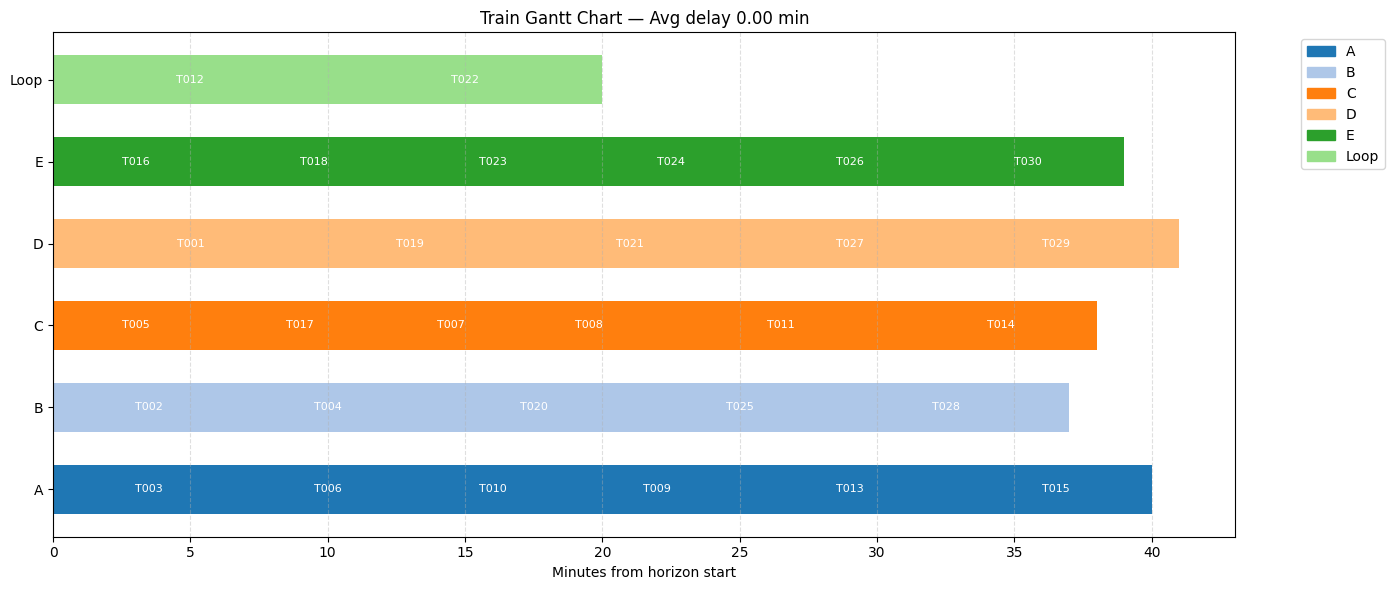

Saved detailed schedule to scheduled_output.csv


In [4]:
# pip installs if needed (uncomment if running in a fresh environment)
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
import os

# ---------------------------
# Configuration / Parameters
# ---------------------------
CSV_PATH = "./station_trains_30.csv"  # change if needed
HORIZON_MINUTES = 180  # scheduling horizon in minutes (from earliest ETA)
TIME_UNIT = 1  # 1 minute time unit
BASE_BUFFER = 1  # base buffer between trains on same track (minutes)
UNCERTAINTY_MARGIN = 1  # multiplier for ETA uncertainty -> buffer
LOOP_PENALTY = 5  # minutes penalty when assigning the Loop track (encourages avoid)
MAX_SOLVE_TIME_S = 30  # seconds to allow the solver
# Map tracks: directionality rules
TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}
PLATFORMS = {  # simple platform model; tracks and platforms are same here (one resource)
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def minutes_between(a, b):
    """Return integer minutes between two (possibly tz-aware) datetimes."""
    return int((b - a).total_seconds() // 60)

# ---------------------------
# Load dataset
# ---------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Please place station_trains_30.csv in notebook folder.")

df = pd.read_csv(CSV_PATH)
print("Dataset preview:")
display(df.head())

# Normalize columns & defaults
if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)

# Parse ETA (ISO8601, UTC) and ETD if present
if 'ETA' in df.columns:
    df['eta'] = pd.to_datetime(df['ETA'], utc=True, errors='coerce')
else:
    # fallback: use now + offsets
    df['eta'] = pd.Timestamp.now(tz='UTC') + pd.to_timedelta(range(len(df)), unit='m')

if 'ETD' in df.columns:
    df['etd'] = pd.to_datetime(df['ETD'], utc=True, errors='coerce')
else:
    df['etd'] = pd.NaT

# Direction normalization: TOP -> top2bottom, BOTTOM -> bottom2top
if 'direction' in df.columns:
    df['direction'] = df['direction'].astype(str).apply(
        lambda x: 'top2bottom' if str(x).strip().upper().startswith('TOP') else 'bottom2top'
    )
else:
    df['direction'] = ['top2bottom' if i % 2 == 0 else 'bottom2top' for i in range(len(df))]

# dwell_time: try to derive from ETD-ETA (minutes), else use column or default
if 'dwell_time' not in df.columns:
    def compute_dwell(row):
        if pd.notnull(row['etd']) and pd.notnull(row['eta']):
            delta = minutes_between(row['eta'], row['etd'])
            return max(1, int(delta))  # at least 1 minute
        return 3
    df['dwell_time'] = df.apply(compute_dwell, axis=1)
else:
    # fill missing with derived or default
    df['dwell_time'] = df['dwell_time'].fillna(
        df.apply(lambda r: minutes_between(r['eta'], r['etd']) if pd.notnull(r.get('etd')) else 3, axis=1)
    ).astype(int)

# priority
if 'priority' not in df.columns:
    df['priority'] = 1
else:
    df['priority'] = df['priority'].fillna(1).astype(int)

# length (meters)
if 'length' not in df.columns:
    df['length'] = 200
else:
    df['length'] = df['length'].fillna(200).astype(int)

# eta_uncertainty: derive from current_delay_s if present, else default 1
if 'eta_uncertainty' not in df.columns:
    if 'current_delay_s' in df.columns:
        df['eta_uncertainty'] = (df['current_delay_s'].fillna(0) / 60).clip(lower=1).astype(int)
    else:
        df['eta_uncertainty'] = 1
else:
    df['eta_uncertainty'] = df['eta_uncertainty'].fillna(1).astype(int)

# Convert ETAs to minutes-from-horizon start (horizon based on earliest ETA in file)
min_eta = df['eta'].min()
horizon_start = min_eta - pd.Timedelta(minutes=5)  # small padding
df['eta_min'] = ((df['eta'] - horizon_start).dt.total_seconds() // 60).astype(int)

# Set traversal/service time estimate (approach + dwell + exit + length factor)
def estimate_service_time(row):
    length_factor = math.ceil(row['length'] / 300)
    return int(2 + row['dwell_time'] + 1 + length_factor * 1)

df['service_time'] = df.apply(estimate_service_time, axis=1)

# Make horizon large enough
horizon = int((df['eta_min'] + df['service_time']).max()) + 60  # minutes buffer

print(f"Scheduling horizon start: {horizon_start}  horizon (min): {horizon} minutes")

# ---------------------------
# Build CP-SAT model
# ---------------------------
model = cp_model.CpModel()

trains = df.to_dict('records')

# variables containers
assign_vars = {}
start_vars = {}
end_vars = {}
interval_vars = {}
delay_vars = {}
chosen_start = {}

# For NoOverlap per track we'll collect intervals per track
track_intervals = {t: [] for t in TRACKS.keys()}

# Build variables per train
for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['service_time'])
    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar

    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar

    model.Add(dvar >= svar - eta_min)
    model.Add(dvar >= 0)

    track_option_binaries = []
    for tr_id, tr_meta in TRACKS.items():
        # enforce directionality
        dir_ok = False
        if tr_meta.get('dir') == 'both':
            dir_ok = True
        elif tr_meta.get('dir') == 'top2bottom' and t['direction'] == 'top2bottom':
            dir_ok = True
        elif tr_meta.get('dir') == 'bottom2top' and t['direction'] == 'bottom2top':
            dir_ok = True
        if not dir_ok:
            continue

        # platform length check
        has_platform = any(PLATFORMS[p]['status'] == 'open' and PLATFORMS[p]['length'] >= t['length'] for p in PLATFORMS)
        if not has_platform:
            continue

        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar

        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)

        # link chosen_start to actual start when assigned
        model.Add(svar == start_var).OnlyEnforceIf(binvar)

    if len(track_option_binaries) == 0:
        raise RuntimeError(f"No feasible track for train {tid} given direction/platform constraints.")
    model.Add(sum(track_option_binaries) == 1)

# No overlap constraints per track (ensures single occupancy)
for tr_id, ivars in track_intervals.items():
    if len(ivars) == 0:
        continue
    model.AddNoOverlap(ivars)

# NOTE: Removed the O(n^2) pairwise ordering/headway block that caused infeasibility.
# If you want a light headway, we can add small separation via alternative approaches later.

# ---------------------------
# Objective: minimize weighted sum of delays + loop use penalty
# ---------------------------
delay_terms = []
for t in trains:
    tid = t['train_id']
    p = int(t['priority'])
    delay_terms.append(delay_vars[tid] * p)

loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr == "Loop":
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen == LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen == 0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)

model.Minimize(sum(delay_terms) + sum(loop_penalty_terms))

# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8

print("Solving (this may take a few seconds)...")
res = solver.Solve(model)
status = solver.StatusName(res)
print("Solver status:", status)
if status not in ("OPTIMAL", "FEASIBLE"):
    raise RuntimeError("Solver did not return a feasible solution.")

# ---------------------------
# Extract solution
# ---------------------------
schedule = []
for t in trains:
    tid = t['train_id']
    chosen = None
    chosen_s = None
    chosen_e = None
    chosen_track_name = None
    for tr_id in TRACKS.keys():
        key = (tid, tr_id)
        if key in assign_vars and solver.Value(assign_vars[key]) == 1:
            chosen = tr_id
            chosen_track_name = tr_id
            chosen_s = solver.Value(start_vars[key])
            chosen_e = solver.Value(end_vars[key])
            break
    if chosen is None:
        chosen_track_name = "UNASSIGNED"
    delay_minutes = solver.Value(delay_vars[tid])
    schedule.append({
        "train_id": tid,
        "direction": t['direction'],
        "assigned_track": chosen_track_name,
        "start_min": chosen_s,
        "end_min": chosen_e,
        "eta_min": int(t['eta_min']),
        "delay_min": int(delay_minutes),
        "priority": int(t['priority']),
        "service_time": int(t['service_time']),
    })

sched_df = pd.DataFrame(schedule)
sched_df['planned_start_dt'] = sched_df['start_min'].apply(lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if not pd.isna(m) else None)
sched_df['planned_end_dt'] = sched_df['end_min'].apply(lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if not pd.isna(m) else None)
print("\nSchedule (sorted by planned start):")
display(sched_df.sort_values(by='planned_start_dt').head(50))

avg_delay = sched_df['delay_min'].mean()
print(f"Average delay (minutes): {avg_delay:.2f}")

# ---------------------------
# Gantt chart
# ---------------------------
tracks = sorted(set(sched_df['assigned_track']))
color_map = {tr: plt.cm.tab20(i % 20) for i, tr in enumerate(tracks)}

fig, ax = plt.subplots(figsize=(14, 6))
y_positions = {tr: i for i, tr in enumerate(tracks)}

for idx, row in sched_df.iterrows():
    tr = row['assigned_track']
    if tr == "UNASSIGNED" or pd.isna(row['start_min']):
        continue
    start = row['start_min']
    dur = row['service_time']
    ax.barh(y_positions[tr], dur, left=start, height=0.6, align='center', color=color_map[tr])
    ax.text(start + dur/2, y_positions[tr], str(row['train_id']), va='center', ha='center', fontsize=8, color='white')

ax.set_yticks([y_positions[t] for t in tracks])
ax.set_yticklabels(tracks)
ax.set_xlabel("Minutes from horizon start")
ax.set_title(f"Train Gantt Chart — Avg delay {avg_delay:.2f} min")
ax.grid(axis='x', linestyle='--', alpha=0.4)

patches = [mpatches.Patch(color=color_map[t], label=t) for t in tracks]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gantt_schedule.png", dpi=150)
print("Gantt chart saved as gantt_schedule.png")
plt.show()

# ---------------------------
# Output summary & save
# ---------------------------
sched_df.to_csv("scheduled_output.csv", index=False)
print("Saved detailed schedule to scheduled_output.csv")


delay cap

FCFS 

whatif senarios in 30 mins

add bufffer

why avg delay is 0

saftey verification

freight trains dont stop at stations

Dataset preview:


,train_id,ETA,ETD,train_type,priority,current_delay_s,direction
0,T001,2025-09-15T10:01:27Z,2025-09-15T10:07:36Z,Freight,3,120,TOP
1,T002,2025-09-15T10:04:21Z,2025-09-15T10:07:48Z,Passenger,6,0,TOP
2,T003,2025-09-15T10:05:23Z,2025-09-15T10:08:40Z,Passenger,6,30,TOP
3,T004,2025-09-15T10:06:55Z,2025-09-15T10:09:19Z,Express,10,0,TOP
4,T005,2025-09-15T10:08:01Z,2025-09-15T10:10:45Z,Special,5,120,TOP


Scheduling horizon start: 2025-09-15 09:56:22+00:00  horizon (min): 104 minutes
Solving (this may take a few seconds)...
Solver status: OPTIMAL

Schedule (sorted by planned start):


,train_id,train_type,direction,assigned_track,start_min,end_min,eta_min,delay_min,priority,service_time,planned_start_dt,planned_end_dt
0,T001,Freight,top2bottom,B,5.0,12.0,5,0,3,4,2025-09-15 10:01:22+00:00,2025-09-15 10:08:22+00:00
19,T020,Freight,bottom2top,C,14.0,20.0,14,0,3,4,2025-09-15 10:10:22+00:00,2025-09-15 10:16:22+00:00
20,T021,Freight,bottom2top,E,16.0,23.0,16,0,3,4,2025-09-15 10:12:22+00:00,2025-09-15 10:19:22+00:00
21,T022,Freight,bottom2top,B,18.0,24.0,18,0,3,4,2025-09-15 10:14:22+00:00,2025-09-15 10:20:22+00:00
10,T011,Freight,top2bottom,B,25.0,31.0,25,0,3,4,2025-09-15 10:21:22+00:00,2025-09-15 10:27:22+00:00
11,T012,Freight,top2bottom,A,27.0,33.0,27,0,3,4,2025-09-15 10:23:22+00:00,2025-09-15 10:29:22+00:00
27,T028,Freight,bottom2top,C,30.0,37.0,30,0,3,4,2025-09-15 10:26:22+00:00,2025-09-15 10:33:22+00:00
28,T029,Freight,bottom2top,B,33.0,39.0,33,0,3,4,2025-09-15 10:29:22+00:00,2025-09-15 10:35:22+00:00
1,T002,Passenger,top2bottom,UNASSIGNED,NaN,NaN,7,0,6,7,NaT,NaT
2,T003,Passenger,top2bottom,UNASSIGNED,NaN,NaN,9,0,6,7,NaT,NaT


Average delay (minutes): 0.00
Gantt chart saved as gantt_schedule.png


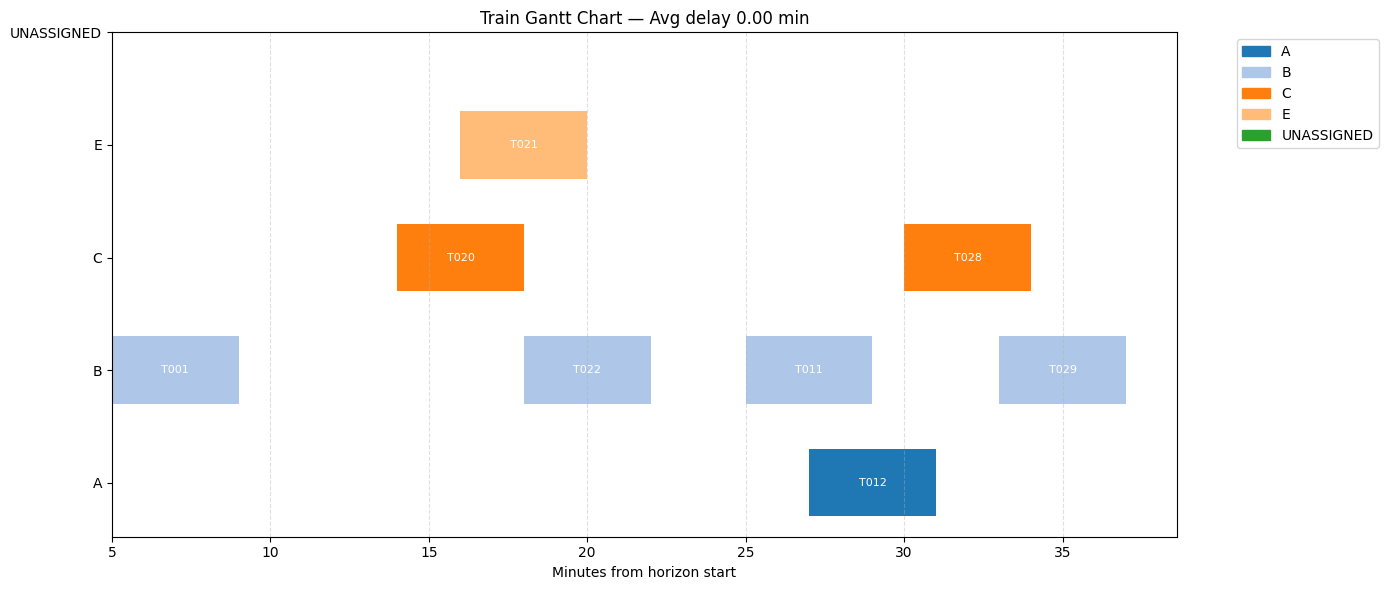

Saved detailed schedule to scheduled_output.csv

=== Key Performance Indicators (KPIs) ===
Average delay (minutes): 0.00
Maximum delay (minutes): 0
Track A utilization: 5.77%
Track B utilization: 24.04%
Track C utilization: 12.50%
Track D utilization: 0.00%
Track E utilization: 6.73%
Track Loop utilization: 0.00%

Saved KPI summary to kpi_summary.csv


,KPI,Value
0,Average Delay (min),0.000000
1,Maximum Delay (min),0.000000
2,Track A Utilization (%),5.769231
3,Track B Utilization (%),24.038462
4,Track C Utilization (%),12.500000
5,Track D Utilization (%),0.000000
6,Track E Utilization (%),6.730769
7,Track Loop Utilization (%),0.000000


In [5]:
# pip installs if needed (uncomment if running in a fresh environment)
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
import os

# ---------------------------
# Configuration / Parameters
# ---------------------------
CSV_PATH = "./station_trains_30.csv"  # change if needed
HORIZON_MINUTES = 180  # scheduling horizon in minutes (from earliest ETA)
BASE_BUFFER = 1        # base buffer between trains on same track (minutes)
UNCERTAINTY_MARGIN = 1 # multiplier for ETA uncertainty -> buffer
LOOP_PENALTY = 5       # minutes penalty when assigning the Loop track
MAX_SOLVE_TIME_S = 30  # seconds to allow the solver

# Map tracks: directionality rules
TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}
PLATFORMS = {
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def minutes_between(a, b):
    return int((b - a).total_seconds() // 60)

# ---------------------------
# Load dataset
# ---------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Place station_trains_30.csv in notebook folder.")

df = pd.read_csv(CSV_PATH)
print("Dataset preview:")
display(df.head())

if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)

# Parse ETA and ETD if present
if 'ETA' in df.columns:
    df['eta'] = pd.to_datetime(df['ETA'], utc=True, errors='coerce')
else:
    df['eta'] = pd.Timestamp.now(tz='UTC') + pd.to_timedelta(range(len(df)), unit='m')
if 'ETD' in df.columns:
    df['etd'] = pd.to_datetime(df['ETD'], utc=True, errors='coerce')
else:
    df['etd'] = pd.NaT

# Normalize direction
if 'direction' in df.columns:
    df['direction'] = df['direction'].astype(str).apply(
        lambda x: 'top2bottom' if str(x).strip().upper().startswith('TOP') else 'bottom2top'
    )
else:
    df['direction'] = ['top2bottom' if i % 2 == 0 else 'bottom2top' for i in range(len(df))]

# dwell_time (freight = 0, others from ETD-ETA or fallback)
def compute_dwell(row):
    if str(row.get('train_type', '')).lower() == "freight":
        return 0
    if pd.notnull(row.get('etd')) and pd.notnull(row.get('eta')):
        delta = minutes_between(row['eta'], row['etd'])
        return max(1, int(delta))
    return 3

df['dwell_time'] = df.apply(compute_dwell, axis=1)

# priority
if 'priority' not in df.columns:
    df['priority'] = 1
else:
    df['priority'] = df['priority'].fillna(1).astype(int)

# length
if 'length' not in df.columns:
    df['length'] = 200
else:
    df['length'] = df['length'].fillna(200).astype(int)

# eta_uncertainty
if 'eta_uncertainty' not in df.columns:
    if 'current_delay_s' in df.columns:
        df['eta_uncertainty'] = (df['current_delay_s'].fillna(0) / 60).clip(lower=1).astype(int)
    else:
        df['eta_uncertainty'] = 1
else:
    df['eta_uncertainty'] = df['eta_uncertainty'].fillna(1).astype(int)

# Horizon start
min_eta = df['eta'].min()
horizon_start = min_eta - pd.Timedelta(minutes=5)
df['eta_min'] = ((df['eta'] - horizon_start).dt.total_seconds() // 60).astype(int)

# Service time + buffer
def estimate_service_time(row):
    length_factor = math.ceil(row['length'] / 300)
    return int(2 + row['dwell_time'] + 1 + length_factor * 1)  # approach + dwell + exit + length
df['service_time'] = df.apply(estimate_service_time, axis=1)
df['buffer'] = BASE_BUFFER + UNCERTAINTY_MARGIN * df['eta_uncertainty']
df['effective_service'] = df['service_time'] + df['buffer']

horizon = int((df['eta_min'] + df['effective_service']).max()) + 60
print(f"Scheduling horizon start: {horizon_start}  horizon (min): {horizon} minutes")

# ---------------------------
# Build CP-SAT model
# ---------------------------
model = cp_model.CpModel()
trains = df.to_dict('records')

assign_vars, start_vars, end_vars, interval_vars = {}, {}, {}, {}
delay_vars, chosen_start = {}, {}
track_intervals = {t: [] for t in TRACKS.keys()}

for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['effective_service'])

    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar
    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar

    # --- Max delay caps per train type ---
    train_type = str(t.get('train_type', '')).lower()
    if train_type == "express":
        model.Add(dvar <= 5)
    elif train_type == "passenger":
        model.Add(dvar <= 10)
    elif train_type == "special":
        model.Add(dvar <= 15)
    elif train_type == "freight":
        model.Add(dvar <= 20)

        track_option_binaries = []
    for tr_id, tr_meta in TRACKS.items():
        dir_ok = (tr_meta['dir'] == 'both' or
                  (tr_meta['dir'] == 'top2bottom' and t['direction'] == 'top2bottom') or
                  (tr_meta['dir'] == 'bottom2top' and t['direction'] == 'bottom2top'))
        if not dir_ok:
            continue

        # --- Platform requirement ---
        if str(t.get('train_type', '')).lower() == "freight":
            has_platform = True   # freight doesn't need platform
        else:
            has_platform = any(PLATFORMS[p]['status'] == 'open' and PLATFORMS[p]['length'] >= t['length'] for p in PLATFORMS)
        if not has_platform:
            continue

        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar
        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)

        # --- enforce start >= ETA and tie delay to actual start ---
        model.Add(start_var >= eta_min).OnlyEnforceIf(binvar)
        model.Add(dvar == start_var - eta_min).OnlyEnforceIf(binvar)

        model.Add(svar == start_var).OnlyEnforceIf(binvar)


    if not track_option_binaries:
        raise RuntimeError(f"No feasible track for train {tid}.")
    model.Add(sum(track_option_binaries) == 1)

for tr_id, ivars in track_intervals.items():
    if ivars:
        model.AddNoOverlap(ivars)

# ---------------------------
# Objective
# ---------------------------
delay_terms = [delay_vars[t['train_id']] * int(t['priority']) for t in trains]
loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr == "Loop":
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen == LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen == 0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)

model.Minimize(sum(delay_terms) + sum(loop_penalty_terms))

# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8

print("Solving (this may take a few seconds)...")
res = solver.Solve(model)
status = solver.StatusName(res)
print("Solver status:", status)
if status not in ("OPTIMAL", "FEASIBLE"):
    raise RuntimeError("Solver did not return a feasible solution.")

# ---------------------------
# Extract solution
# ---------------------------
schedule = []
for t in trains:
    tid = t['train_id']
    chosen_track_name, chosen_s, chosen_e = "UNASSIGNED", None, None
    for tr_id in TRACKS.keys():
        key = (tid, tr_id)
        if key in assign_vars and solver.Value(assign_vars[key]) == 1:
            chosen_track_name = tr_id
            chosen_s = solver.Value(start_vars[key])
            chosen_e = solver.Value(end_vars[key])
            break
    delay_minutes = solver.Value(delay_vars[tid])
    schedule.append({
        "train_id": tid,
        "train_type": t.get('train_type', 'Unknown'),
        "direction": t['direction'],
        "assigned_track": chosen_track_name,
        "start_min": chosen_s,
        "end_min": chosen_e,
        "eta_min": int(t['eta_min']),
        "delay_min": int(delay_minutes),
        "priority": int(t['priority']),
        "service_time": int(t['service_time']),
    })

sched_df = pd.DataFrame(schedule)
sched_df['planned_start_dt'] = sched_df['start_min'].apply(
    lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)
sched_df['planned_end_dt'] = sched_df['end_min'].apply(
    lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)

print("\nSchedule (sorted by planned start):")
display(sched_df.sort_values(by='planned_start_dt').head(50))

avg_delay = sched_df['delay_min'].mean()
print(f"Average delay (minutes): {avg_delay:.2f}")

# ---------------------------
# Gantt chart
# ---------------------------
tracks = sorted(set(sched_df['assigned_track']))
color_map = {tr: plt.cm.tab20(i % 20) for i, tr in enumerate(tracks)}

fig, ax = plt.subplots(figsize=(14, 6))
y_positions = {tr: i for i, tr in enumerate(tracks)}

for _, row in sched_df.iterrows():
    tr = row['assigned_track']
    if tr == "UNASSIGNED" or pd.isna(row['start_min']):
        continue
    start, dur = row['start_min'], row['service_time']
    ax.barh(y_positions[tr], dur, left=start, height=0.6, align='center', color=color_map[tr])
    ax.text(start + dur/2, y_positions[tr], str(row['train_id']),
            va='center', ha='center', fontsize=8, color='white')

ax.set_yticks([y_positions[t] for t in tracks])
ax.set_yticklabels(tracks)
ax.set_xlabel("Minutes from horizon start")
ax.set_title(f"Train Gantt Chart — Avg delay {avg_delay:.2f} min")
ax.grid(axis='x', linestyle='--', alpha=0.4)

patches = [mpatches.Patch(color=color_map[t], label=t) for t in tracks]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gantt_schedule.png", dpi=150)
print("Gantt chart saved as gantt_schedule.png")
plt.show()

# ---------------------------
# Save
# ---------------------------
sched_df.to_csv("scheduled_output.csv", index=False)
print("Saved detailed schedule to scheduled_output.csv")

# ---------------------------
# KPIs
# ---------------------------
print("\n=== Key Performance Indicators (KPIs) ===")

# Average delay (already computed)
print(f"Average delay (minutes): {avg_delay:.2f}")

# Maximum delay
max_delay = sched_df['delay_min'].max()
print(f"Maximum delay (minutes): {max_delay}")

# Utilization per track
track_utilization = {}
for tr in TRACKS.keys():
    total_time = 0
    for _, row in sched_df[sched_df['assigned_track'] == tr].iterrows():
        if pd.notna(row['start_min']) and pd.notna(row['end_min']):
            total_time += row['end_min'] - row['start_min']
    utilization_pct = (total_time / horizon) * 100
    track_utilization[tr] = utilization_pct
    print(f"Track {tr} utilization: {utilization_pct:.2f}%")

# Summary dataframe for easier export/plotting if needed
kpi_df = pd.DataFrame([
    {"KPI": "Average Delay (min)", "Value": avg_delay},
    {"KPI": "Maximum Delay (min)", "Value": max_delay},
] + [
    {"KPI": f"Track {tr} Utilization (%)", "Value": util}
    for tr, util in track_utilization.items()
])

kpi_df.to_csv("kpi_summary.csv", index=False)
print("\nSaved KPI summary to kpi_summary.csv")
display(kpi_df)


Dataset preview:


,train_id,ETA,ETD,train_type,priority,current_delay_s,direction
0,T001,2025-09-15T10:01:27Z,2025-09-15T10:07:36Z,Freight,3,120,TOP
1,T002,2025-09-15T10:04:21Z,2025-09-15T10:07:48Z,Passenger,6,0,TOP
2,T003,2025-09-15T10:05:23Z,2025-09-15T10:08:40Z,Passenger,6,30,TOP
3,T004,2025-09-15T10:06:55Z,2025-09-15T10:09:19Z,Express,10,0,TOP
4,T005,2025-09-15T10:08:01Z,2025-09-15T10:10:45Z,Special,5,120,TOP


Scheduling horizon start: 2025-09-15 09:56:22+00:00  horizon (min): 104 minutes
Solving (this may take a few seconds)...
Solver status: FEASIBLE

Schedule (sorted by planned start):


,train_id,train_type,direction,assigned_track,start_min,end_min,eta_min,delay_min,priority,service_time,planned_start_dt,planned_end_dt
0,T001,Freight,top2bottom,D,5,12,5,0,3,4,2025-09-15 10:01:22+00:00,2025-09-15 10:08:22+00:00
15,T016,Special,bottom2top,C,5,13,5,0,5,6,2025-09-15 10:01:22+00:00,2025-09-15 10:09:22+00:00
1,T002,Passenger,top2bottom,B,7,16,7,0,6,7,2025-09-15 10:03:22+00:00,2025-09-15 10:12:22+00:00
2,T003,Passenger,top2bottom,A,9,18,9,0,6,7,2025-09-15 10:05:22+00:00,2025-09-15 10:14:22+00:00
17,T018,Passenger,bottom2top,E,9,19,9,0,6,7,2025-09-15 10:05:22+00:00,2025-09-15 10:15:22+00:00
3,T004,Express,top2bottom,Loop,10,18,10,0,10,6,2025-09-15 10:06:22+00:00,2025-09-15 10:14:22+00:00
4,T005,Special,top2bottom,D,12,21,11,1,5,6,2025-09-15 10:08:22+00:00,2025-09-15 10:17:22+00:00
16,T017,Special,bottom2top,C,13,21,8,5,5,6,2025-09-15 10:09:22+00:00,2025-09-15 10:17:22+00:00
6,T007,Express,top2bottom,B,16,23,16,0,10,5,2025-09-15 10:12:22+00:00,2025-09-15 10:19:22+00:00
7,T008,Express,top2bottom,A,18,25,17,1,10,5,2025-09-15 10:14:22+00:00,2025-09-15 10:21:22+00:00


Average delay (minutes): 5.33
Gantt chart saved as gantt_schedule.png


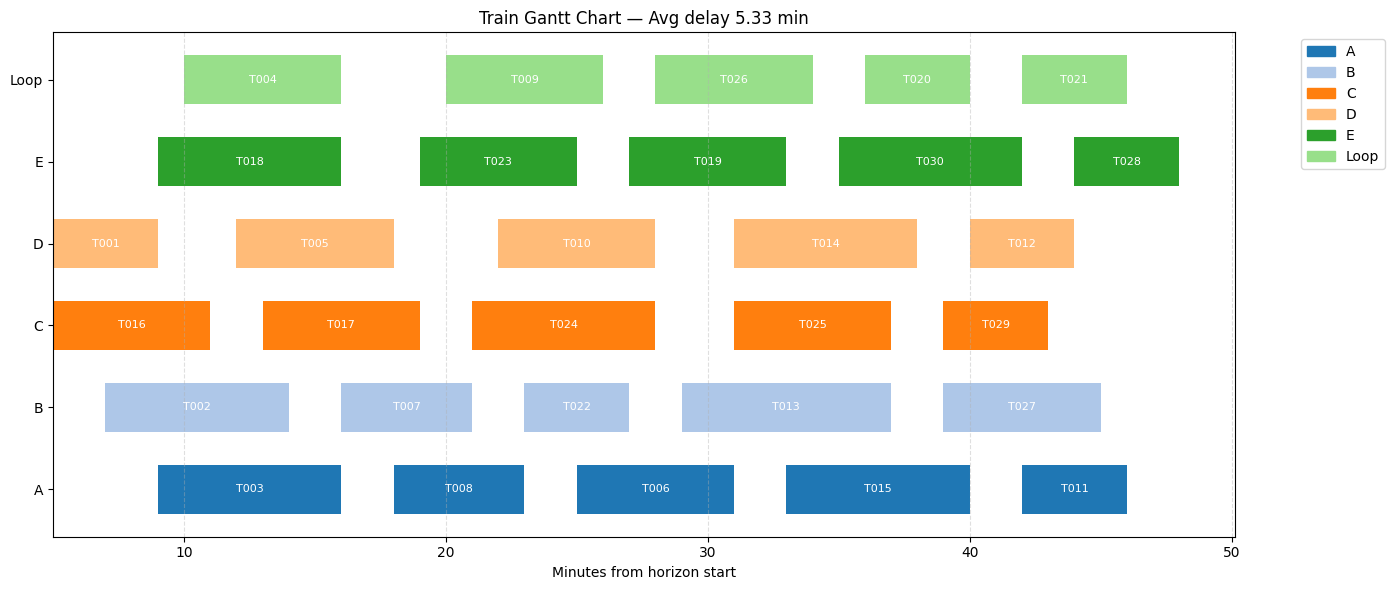

Saved detailed schedule to scheduled_output.csv

=== Key Performance Indicators (KPIs) ===
Average delay (minutes): 5.33
Maximum delay (minutes): 26
Track A utilization: 37.50%
Track B utilization: 39.42%
Track C utilization: 38.46%
Track D utilization: 38.46%
Track E utilization: 40.38%
Track Loop utilization: 35.58%

Saved KPI summary to kpi_summary.csv


,KPI,Value
0,Average Delay (min),5.333333
1,Maximum Delay (min),26.000000
2,Track A Utilization (%),37.500000
3,Track B Utilization (%),39.423077
4,Track C Utilization (%),38.461538
5,Track D Utilization (%),38.461538
6,Track E Utilization (%),40.384615
7,Track Loop Utilization (%),35.576923


In [6]:
# pip installs if needed (uncomment if running in a fresh environment)
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
import os

# ---------------------------
# Configuration / Parameters
# ---------------------------
CSV_PATH = "./station_trains_30.csv"  # change if needed
HORIZON_MINUTES = 180  # scheduling horizon in minutes (from earliest ETA)
BASE_BUFFER = 1        # base buffer between trains on same track (minutes)
UNCERTAINTY_MARGIN = 1 # multiplier for ETA uncertainty -> buffer
LOOP_PENALTY = 5       # minutes penalty when assigning the Loop track
MAX_SOLVE_TIME_S = 30  # seconds to allow the solver

# Map tracks: directionality rules
TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}
PLATFORMS = {
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def minutes_between(a, b):
    return int((b - a).total_seconds() // 60)

# ---------------------------
# Load dataset
# ---------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Place station_trains_30.csv in notebook folder.")

df = pd.read_csv(CSV_PATH)
print("Dataset preview:")
display(df.head())

if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)

# Parse ETA and ETD if present
if 'ETA' in df.columns:
    df['eta'] = pd.to_datetime(df['ETA'], utc=True, errors='coerce')
else:
    df['eta'] = pd.Timestamp.now(tz='UTC') + pd.to_timedelta(range(len(df)), unit='m')
if 'ETD' in df.columns:
    df['etd'] = pd.to_datetime(df['ETD'], utc=True, errors='coerce')
else:
    df['etd'] = pd.NaT

# Normalize direction
if 'direction' in df.columns:
    df['direction'] = df['direction'].astype(str).apply(
        lambda x: 'top2bottom' if str(x).strip().upper().startswith('TOP') else 'bottom2top'
    )
else:
    df['direction'] = ['top2bottom' if i % 2 == 0 else 'bottom2top' for i in range(len(df))]

# dwell_time (freight = 0, others from ETD-ETA or fallback)
def compute_dwell(row):
    if str(row.get('train_type', '')).lower() == "freight":
        return 0
    if pd.notnull(row.get('etd')) and pd.notnull(row.get('eta')):
        delta = minutes_between(row['eta'], row['etd'])
        return max(1, int(delta))
    return 3

df['dwell_time'] = df.apply(compute_dwell, axis=1)

# priority
if 'priority' not in df.columns:
    df['priority'] = 1
else:
    df['priority'] = df['priority'].fillna(1).astype(int)

# length
if 'length' not in df.columns:
    df['length'] = 200
else:
    df['length'] = df['length'].fillna(200).astype(int)

# eta_uncertainty
if 'eta_uncertainty' not in df.columns:
    if 'current_delay_s' in df.columns:
        df['eta_uncertainty'] = (df['current_delay_s'].fillna(0) / 60).clip(lower=1).astype(int)
    else:
        df['eta_uncertainty'] = 1
else:
    df['eta_uncertainty'] = df['eta_uncertainty'].fillna(1).astype(int)

# Horizon start
min_eta = df['eta'].min()
horizon_start = min_eta - pd.Timedelta(minutes=5)
df['eta_min'] = ((df['eta'] - horizon_start).dt.total_seconds() // 60).astype(int)

# Service time + buffer
def estimate_service_time(row):
    length_factor = math.ceil(row['length'] / 300)
    return int(2 + row['dwell_time'] + 1 + length_factor * 1)  # approach + dwell + exit + length
df['service_time'] = df.apply(estimate_service_time, axis=1)
df['buffer'] = BASE_BUFFER + UNCERTAINTY_MARGIN * df['eta_uncertainty']
df['effective_service'] = df['service_time'] + df['buffer']

horizon = int((df['eta_min'] + df['effective_service']).max()) + 60
print(f"Scheduling horizon start: {horizon_start}  horizon (min): {horizon} minutes")

# ---------------------------
# Build CP-SAT model
# ---------------------------
model = cp_model.CpModel()
trains = df.to_dict('records')

assign_vars, start_vars, end_vars, interval_vars = {}, {}, {}, {}
delay_vars, chosen_start = {}, {}
track_intervals = {t: [] for t in TRACKS.keys()}

for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['effective_service'])

    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar
    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar

    track_option_binaries = []
    for tr_id, tr_meta in TRACKS.items():
        dir_ok = (tr_meta['dir'] == 'both' or
                  (tr_meta['dir'] == 'top2bottom' and t['direction'] == 'top2bottom') or
                  (tr_meta['dir'] == 'bottom2top' and t['direction'] == 'bottom2top'))
        if not dir_ok:
            continue

        # --- Platform requirement ---
        if str(t.get('train_type', '')).lower() == "freight":
            has_platform = True   # freight doesn't need platform
        else:
            has_platform = any(PLATFORMS[p]['status'] == 'open' and PLATFORMS[p]['length'] >= t['length'] for p in PLATFORMS)
        if not has_platform:
            continue

        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar
        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)

        # --- enforce start >= ETA and tie delay to actual start ---
        model.Add(start_var >= eta_min).OnlyEnforceIf(binvar)
        model.Add(dvar == start_var - eta_min).OnlyEnforceIf(binvar)
        model.Add(svar == start_var).OnlyEnforceIf(binvar)

    if not track_option_binaries:
        raise RuntimeError(f"No feasible track for train {tid}.")
    model.Add(sum(track_option_binaries) == 1)

for tr_id, ivars in track_intervals.items():
    if ivars:
        model.AddNoOverlap(ivars)

# ---------------------------
# Objective (soft delay penalties)
# ---------------------------
delay_terms = []
for t in trains:
    tid = t['train_id']
    dvar = delay_vars[tid]
    train_type = str(t.get('train_type', '')).lower()

    if train_type == "express":
        weight = 100
    elif train_type == "passenger":
        weight = 50
    elif train_type == "special":
        weight = 20
    elif train_type == "freight":
        weight = 10
    else:
        weight = 30  # default fallback

    delay_terms.append(dvar * weight)

# Loop penalties
loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr == "Loop":
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen == LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen == 0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)

# Final objective
model.Minimize(sum(delay_terms) + sum(loop_penalty_terms))

# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8

print("Solving (this may take a few seconds)...")
res = solver.Solve(model)
status = solver.StatusName(res)
print("Solver status:", status)
if status not in ("OPTIMAL", "FEASIBLE"):
    raise RuntimeError("Solver did not return a feasible solution.")

# ---------------------------
# Extract solution
# ---------------------------
schedule = []
for t in trains:
    tid = t['train_id']
    chosen_track_name, chosen_s, chosen_e = "UNASSIGNED", None, None
    for tr_id in TRACKS.keys():
        key = (tid, tr_id)
        if key in assign_vars and solver.Value(assign_vars[key]) == 1:
            chosen_track_name = tr_id
            chosen_s = solver.Value(start_vars[key])
            chosen_e = solver.Value(end_vars[key])
            break
    delay_minutes = solver.Value(delay_vars[tid])
    schedule.append({
        "train_id": tid,
        "train_type": t.get('train_type', 'Unknown'),
        "direction": t['direction'],
        "assigned_track": chosen_track_name,
        "start_min": chosen_s,
        "end_min": chosen_e,
        "eta_min": int(t['eta_min']),
        "delay_min": int(delay_minutes),
        "priority": int(t['priority']),
        "service_time": int(t['service_time']),
    })

sched_df = pd.DataFrame(schedule)
sched_df['planned_start_dt'] = sched_df['start_min'].apply(
    lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)
sched_df['planned_end_dt'] = sched_df['end_min'].apply(
    lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)

print("\nSchedule (sorted by planned start):")
display(sched_df.sort_values(by='planned_start_dt').head(50))

avg_delay = sched_df['delay_min'].mean()
print(f"Average delay (minutes): {avg_delay:.2f}")

# ---------------------------
# Gantt chart
# ---------------------------
tracks = sorted(set(sched_df['assigned_track']))
color_map = {tr: plt.cm.tab20(i % 20) for i, tr in enumerate(tracks)}

fig, ax = plt.subplots(figsize=(14, 6))
y_positions = {tr: i for i, tr in enumerate(tracks)}

for _, row in sched_df.iterrows():
    tr = row['assigned_track']
    if tr == "UNASSIGNED" or pd.isna(row['start_min']):
        continue
    start, dur = row['start_min'], row['service_time']
    ax.barh(y_positions[tr], dur, left=start, height=0.6, align='center', color=color_map[tr])
    ax.text(start + dur/2, y_positions[tr], str(row['train_id']),
            va='center', ha='center', fontsize=8, color='white')

ax.set_yticks([y_positions[t] for t in tracks])
ax.set_yticklabels(tracks)
ax.set_xlabel("Minutes from horizon start")
ax.set_title(f"Train Gantt Chart — Avg delay {avg_delay:.2f} min")
ax.grid(axis='x', linestyle='--', alpha=0.4)

patches = [mpatches.Patch(color=color_map[t], label=t) for t in tracks]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gantt_schedule.png", dpi=150)
print("Gantt chart saved as gantt_schedule.png")
plt.show()

# ---------------------------
# Save
# ---------------------------
sched_df.to_csv("scheduled_output.csv", index=False)
print("Saved detailed schedule to scheduled_output.csv")

# ---------------------------
# KPIs
# ---------------------------
print("\n=== Key Performance Indicators (KPIs) ===")

# Average delay (already computed)
print(f"Average delay (minutes): {avg_delay:.2f}")

# Maximum delay
max_delay = sched_df['delay_min'].max()
print(f"Maximum delay (minutes): {max_delay}")

# Utilization per track
track_utilization = {}
for tr in TRACKS.keys():
    total_time = 0
    for _, row in sched_df[sched_df['assigned_track'] == tr].iterrows():
        if pd.notna(row['start_min']) and pd.notna(row['end_min']):
            total_time += row['end_min'] - row['start_min']
    utilization_pct = (total_time / horizon) * 100
    track_utilization[tr] = utilization_pct
    print(f"Track {tr} utilization: {utilization_pct:.2f}%")

# Summary dataframe for easier export/plotting if needed
kpi_df = pd.DataFrame([
    {"KPI": "Average Delay (min)", "Value": avg_delay},
    {"KPI": "Maximum Delay (min)", "Value": max_delay},
] + [
    {"KPI": f"Track {tr} Utilization (%)", "Value": util}
    for tr, util in track_utilization.items()
])

kpi_df.to_csv("kpi_summary.csv", index=False)
print("\nSaved KPI summary to kpi_summary.csv")
display(kpi_df)


1.all tracks nearly equaal utilization